# Modeling

## Step 0: Import Your Libraries

In [2]:
# Notebook setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# XGBoost (make sure the package is installed: pip install xgboost)
import xgboost as xgb

RANDOM_STATE = 42
TEST_SIZE = 0.20

pd.set_option("display.precision", 3)
pd.set_option("display.max_columns", 50)


## Step 1: Load the Dataset

In [3]:
# File
df = pd.read_pickle("../data/modeling_all_counties.pkl")
print(df.shape)
df.head()

(958, 27)


,cohortstudents,graduation_rate,met_uccsu_grad_reqs_rate,seal_of_biliteracy_rate,still_enrolled_rate,chronicabsenteeismrate,unexcused_absences_percent,outofschool_suspension_absences_percent,percent__eligible_free_k12,frpm_count_k12,stu_tch_ratio,stu_adm_ratio,stu_psv_ratio,pct_associate,pct_bachelors,pct_bachelors_plus,pct_master,pct_master_plus,pct_doctorate,pct_juris_doctor,pct_no_degree,pct_experienced,pct_second_year,grade_retention_ratio,pct_senior_cohort,school_climate_index,high_grad_rate
0,394.0,92.4,73.9,22.8,1.0,12.7,23.5,0.5,0.172,327.0,23.3,452.0,361.6,0.0,0.126,0.316,0.126,0.347,0.021,0.0,0.063,0.863,0.032,1.059,0.499,0.517,Graduated / On Track
1,284.0,95.1,67.8,21.5,0.0,70.3,46.2,0.4,0.174,307.0,22.0,414.0,274.7,0.0,0.167,0.264,0.342,0.080,0.011,0.0,0.000,0.895,0.038,0.997,0.501,0.517,Graduated / On Track
2,861.0,90.5,62.3,12.1,0.8,5.2,24.1,0.0,0.262,935.0,19.2,374.7,228.7,0.0,0.428,0.148,0.360,0.047,0.017,0.0,0.000,0.856,0.051,1.015,0.496,0.517,Graduated / On Track
3,672.0,96.4,72.8,25.0,0.0,3.5,28.0,0.9,0.166,491.0,22.6,396.9,178.2,0.0,0.188,0.315,0.161,0.315,0.020,0.0,0.000,0.913,0.034,0.830,0.470,0.517,Graduated / On Track
5,40.0,95.0,76.3,0.0,0.0,29.6,67.9,0.0,0.551,102.0,11.6,176.0,274.7,0.0,0.333,0.167,0.333,0.167,0.000,0.0,0.000,1.000,0.000,1.171,0.545,0.517,Graduated / On Track


## Step 2: Define the Target Variable and Handle Data Leakage

In [4]:
# Define the Target and Handle Data Leakage

if "low_grad_rate" in df.columns:
    TARGET = "low_grad_rate"
    y = df[TARGET].astype(int)
else:
    if "graduation_rate" not in df.columns:
        raise KeyError("No 'graduation_rate' or 'low_grad_rate' column found.")
    TARGET = "low_grad_rate"
    y = (df["graduation_rate"] < 90).astype(int)
    df[TARGET] = y

print("Target positive rate (1 = low grad):", y.mean().round(4))

# Columns that leak the label or are the label itself
LEAKAGE = [
    TARGET,
    "high_grad_rate",       
    "graduation_rate"      
]

# Drop leakage columns (if they exist)
cols_to_drop_now = [c for c in LEAKAGE if c in df.columns]
X = df.drop(columns=cols_to_drop_now, errors="ignore")

print("After leakage drop, num columns:", X.shape[1])
X.head()

Target positive rate (1 = low grad): 0.263
After leakage drop, num columns: 25


,cohortstudents,met_uccsu_grad_reqs_rate,seal_of_biliteracy_rate,still_enrolled_rate,chronicabsenteeismrate,unexcused_absences_percent,outofschool_suspension_absences_percent,percent__eligible_free_k12,frpm_count_k12,stu_tch_ratio,stu_adm_ratio,stu_psv_ratio,pct_associate,pct_bachelors,pct_bachelors_plus,pct_master,pct_master_plus,pct_doctorate,pct_juris_doctor,pct_no_degree,pct_experienced,pct_second_year,grade_retention_ratio,pct_senior_cohort,school_climate_index
0,394.0,73.9,22.8,1.0,12.7,23.5,0.5,0.172,327.0,23.3,452.0,361.6,0.0,0.126,0.316,0.126,0.347,0.021,0.0,0.063,0.863,0.032,1.059,0.499,0.517
1,284.0,67.8,21.5,0.0,70.3,46.2,0.4,0.174,307.0,22.0,414.0,274.7,0.0,0.167,0.264,0.342,0.080,0.011,0.0,0.000,0.895,0.038,0.997,0.501,0.517
2,861.0,62.3,12.1,0.8,5.2,24.1,0.0,0.262,935.0,19.2,374.7,228.7,0.0,0.428,0.148,0.360,0.047,0.017,0.0,0.000,0.856,0.051,1.015,0.496,0.517
3,672.0,72.8,25.0,0.0,3.5,28.0,0.9,0.166,491.0,22.6,396.9,178.2,0.0,0.188,0.315,0.161,0.315,0.020,0.0,0.000,0.913,0.034,0.830,0.470,0.517
5,40.0,76.3,0.0,0.0,29.6,67.9,0.0,0.551,102.0,11.6,176.0,274.7,0.0,0.333,0.167,0.333,0.167,0.000,0.0,0.000,1.000,0.000,1.171,0.545,0.517


## Step 3: Split the Data

In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((766, 25), (192, 25), np.float64(0.26240208877284593), np.float64(0.265625))

## Step 3.1 Feature selection for all_counties and Use Random Forest to pick top features

In [6]:
# Feature Selection Using Random Forest Feature Importances

rf_full = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=3,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Original number of features:", X_train.shape[1])

rf_full.fit(X_train, y_train)

importances = (
    pd.Series(rf_full.feature_importances_, index=X_train.columns)
      .sort_values(ascending=False)
)

print("\nTop 20 features by importance:")
display(importances.head(20))

# Choose top N features to keep
TOP_N = 15
top_features = importances.head(TOP_N).index.tolist()

print(f"\nKeeping top {TOP_N} features:")
print(top_features)

# Reduce X_train / X_test to only those features
X_train = X_train[top_features].copy()
X_test = X_test[top_features].copy()

print("\nReduced number of features:", X_train.shape[1])

Original number of features: 25

Top 20 features by importance:


still_enrolled_rate                        0.186
chronicabsenteeismrate                     0.167
unexcused_absences_percent                 0.078
met_uccsu_grad_reqs_rate                   0.072
percent__eligible_free_k12                 0.071
frpm_count_k12                             0.036
stu_tch_ratio                              0.030
pct_experienced                            0.028
cohortstudents                             0.027
pct_senior_cohort                          0.027
stu_adm_ratio                              0.026
grade_retention_ratio                      0.026
pct_bachelors_plus                         0.023
stu_psv_ratio                              0.023
pct_bachelors                              0.023
pct_master                                 0.022
seal_of_biliteracy_rate                    0.020
outofschool_suspension_absences_percent    0.020
pct_master_plus                            0.019
school_climate_index                       0.019
dtype: float64


Keeping top 15 features:
['still_enrolled_rate', 'chronicabsenteeismrate', 'unexcused_absences_percent', 'met_uccsu_grad_reqs_rate', 'percent__eligible_free_k12', 'frpm_count_k12', 'stu_tch_ratio', 'pct_experienced', 'cohortstudents', 'pct_senior_cohort', 'stu_adm_ratio', 'grade_retention_ratio', 'pct_bachelors_plus', 'stu_psv_ratio', 'pct_bachelors']

Reduced number of features: 15


## Step 3.2 Define the Models

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb

models = {
    "Logistic Regression": LogisticRegression(
        class_weight="balanced",
        max_iter=2000,
        random_state=RANDOM_STATE
    ),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=3,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=RANDOM_STATE
    ),
    "XGBoost": xgb.XGBClassifier(
        eval_metric="logloss",
        scale_pos_weight=(len(y_train) / y_train.sum()),
        use_label_encoder=False
    ),
    "SVM": SVC(
        kernel="rbf",
        probability=True,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced",
        max_depth=None,
        min_samples_leaf=5,
        random_state=RANDOM_STATE
    ),
    "KNN": KNeighborsClassifier()
}

## Step 4: Define Evaluation Function for Precision-Recall Analysis

In [10]:
# Evaluation helper

def evaluate_pr(model_name, y_true, y_proba):
    """
    y_proba: predicted probabilities for class 1
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)

    # Hard predictions at 0.5 for the report
    y_pred = (y_proba > 0.5).astype(int)

    print(f"===== {model_name} =====")
    print(classification_report(y_true, y_pred, digits=3))
    print("PR-AUC:", round(pr_auc, 4))

    # Plot PR curve
    plt.figure(figsize=(5, 4))
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve: {model_name} (AP={pr_auc:.3f})")
    plt.grid(True)
    plt.show()

    return pr_auc


## Step 5: Train Additional Models and Build Comparison Table

In [ ]:
models = {
    "Logistic Regression": logit_clf,  
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=3,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=RANDOM_STATE
    ),
    "XGBoost": xgb.XGBClassifier(
        eval_metric="logloss",
        use_label_encoder=False,
        scale_pos_weight=(len(y_train) / y_train.sum()),
        random_state=RANDOM_STATE
    ),
    "SVM": Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", SVC(
            kernel="rbf",
            probability=True,
            class_weight="balanced",
            random_state=RANDOM_STATE
        ))
    ]),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=None,
        min_samples_leaf=3,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "KNN": Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ])
}

rows = []

for model_name, model in models.items():
    print("\n==============================")
    print("Training:", model_name)
    model.fit(X_train, y_train)

    # probability for class 1
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # SVM decision_function backup 
        scores = model.decision_function(X_test)
        # map scores to [0,1] via a logistic transform
        y_proba = 1 / (1 + np.exp(-scores))

    pr_auc = average_precision_score(y_test, y_proba)
    y_pred = (y_proba > 0.5).astype(int)

    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"PR-AUC: {pr_auc:.4f}")

    rows.append({
        "Model": model_name,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "PR-AUC": pr_auc
    })

# Comparison table
comparison_df = (
    pd.DataFrame(rows)
      .sort_values(by="PR-AUC", ascending=False)
      .reset_index(drop=True)
)

comparison_df


Training: Logistic Regression
PR-AUC: 0.7563

Training: Naive Bayes
PR-AUC: 0.7554

Training: Random Forest
PR-AUC: 0.7745

Training: XGBoost
PR-AUC: 0.7072

Training: SVM
PR-AUC: 0.7339

Training: Decision Tree
PR-AUC: 0.4717

Training: KNN
PR-AUC: 0.7062


c:\Users\tanya\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:39:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Precision,Recall,F1-Score,PR-AUC
0,Random Forest,0.720,0.706,0.713,0.775
1,Logistic Regression,0.548,0.784,0.645,0.756
2,Naive Bayes,0.547,0.686,0.609,0.755
3,SVM,0.711,0.627,0.667,0.734
4,XGBoost,0.702,0.647,0.673,0.707
5,KNN,0.811,0.588,0.682,0.706
6,Decision Tree,0.477,0.608,0.534,0.472


# Step 6: Make a Bar Chart of PR-AUC for all models

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

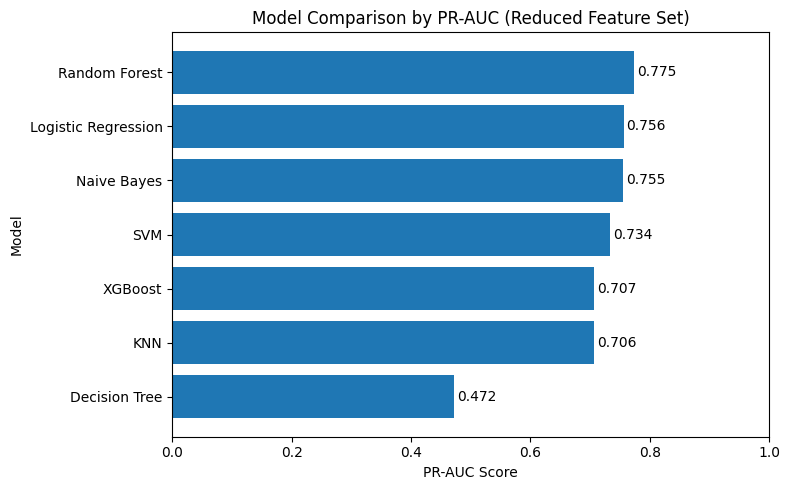

In [16]:

plt.figure(figsize=(8, 5))

plt.barh(
    comparison_df["Model"],
    comparison_df["PR-AUC"],
)

plt.xlabel("PR-AUC Score")
plt.ylabel("Model")
plt.title("Model Comparison by PR-AUC (Reduced Feature Set)")

# Put value labels 
for i, v in enumerate(comparison_df["PR-AUC"]):
    plt.text(v + 0.005, i, f"{v:.3f}", va="center")

plt.xlim(0, 1.0)
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

# Step 7: Precision–Recall curves for all models on the reduced feature set

Plotting PR curve for: Logistic Regression
Plotting PR curve for: Naive Bayes
Plotting PR curve for: Random Forest
Plotting PR curve for: XGBoost
Plotting PR curve for: SVM
Plotting PR curve for: Decision Tree
Plotting PR curve for: KNN


c:\Users\tanya\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:46:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


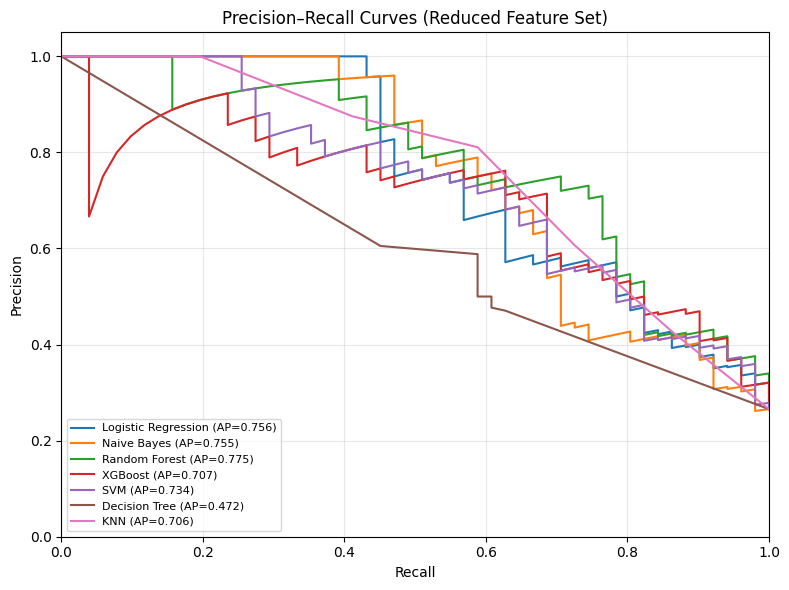

In [17]:
plt.figure(figsize=(8, 6))

for model_name, model in models.items():
    print(f"Plotting PR curve for: {model_name}")
    # Refit with reduced train set
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)

    plt.plot(recall, precision, label=f"{model_name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Reduced Feature Set)")
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.legend(loc="lower left", fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

In order to create an effective Early Warning System for all available counties using clean and reliable data, we wanted to take advantage of the data from the counties’ safety climates. However, when looking further at the safety climate data, we saw that there were seven counties missing all safety climate data. And what we also determined is that the missingness of this data was non-random; therefore, if we keep the safety climate data in our model we would be forced to exclude the seven counties as well as potentially introduce bias.

Because of this, we decided to run a Random Forest Feature Importance model on the entire dataset with the safety climate data included, and the climate variables were never selected as one of the top predictors. This provided us evidence to safely remove the safety climate data columns without negatively affecting the model’s performance.

Following the removal of the safety climate data, we ran another Random Forest Feature Reduction on the dataset, and retained the top 15 predictors. We found that the models that used the 15 features we selected to retain produced results nearly identical or better than models that retained all features; and Random Forest continued to perform the best with the highest PR-AUC score.

Ultimately, this method retains each county, removes potential biased data, reduces the complexity of the model, while retaining high levels of predictive performance.